## from book - 파이썬으로 텍스트 분석하기(늘봄)

# 네이버 블로그 내용 가져오기

## 스크래핑을 위한 라이브러리
네이버 검색 API와 Beautiful Soup 4를 이용하여 네이버 블로그 텍스트 데이터를 수집하기 위해서는 먼저 스크래핑에 필요한 여러 라이브러리를 import해야한다. 정규표현식을 사용하기 위해 re 라이브러리를 import하고, 네이버 API를 통해 가져온 JSON 파일을 처리하기위해 json 라이브러리를 import한다. 그리고 수학 라이브러리 math와 http 통신을 위해서 사용하는 requests 라이브러리를 import하고, 웹과 관련된 내용을 편리하게 처리하기 위해 urllib 라이브러리를 import 한다. 마지막으로 HTML과 XML을 파싱하는 데에 사용되는 파이썬 라이브러리 BeautifulSoup를 import하여 블로그 내용을 가져오기 위해 사용한다.

In [ ]:
import re
import json
import math
import requests
import urllib.request
import urllib.error
import urllib.parse
from bs4 import BeautifulSoup
import pandas as pd

## 네이버 개발자 사이트에서 ID와 Secret 얻기
네이버에서 제공하는 API를 이용하려면 네이버 개발자 사이트 https://developers.naver.com 에서 어플리케이션 등록 후, Client ID는 naver_clinet_id에 넣고, Client Secret은 naver_client_secret에 넣는다.

In [ ]:
naver_client_id = "4zjZ2m1cpG8bsWtiVx0X"
naver_client_secret = "yPdLCpxrca"

## 네이버 블로그 갯수 가져오기


In [ ]:
def get_blog_count(query, display): #검색어 해당하는 블로그 전체 개수 가져오기
    encode_query = urllib.parse.quote(query)
    search_url = "https://openapi.naver.com/v1/search/blog?query=" + encode_query
    request = urllib.request.Request(search_url) 

    request.add_header("X-Naver-Client-Id", naver_client_id)  #헤더추가
    request.add_header("X-Naver-Client-Secret", naver_client_secret)

    response = urllib.request.urlopen(request) #실제 사이트에 해당하는 결과 요청
    response_code = response.getcode()  #반환되는 코드 확인

    if response_code is 200: # 서버가 요청을 제대로 처리한 경우
        response_body = response.read()
        response_body_dict = json.loads(response_body.decode('utf-8'))  # 네이버가 제공하는 JSON파일로 읽기

        print("Last build date: " + str(response_body_dict['lastBuildDate']))  # JSON 출력 중 해당 항목의 필드를 가져와 출력
        print("Total: " + str(response_body_dict['total']))
        print("Start: " + str(response_body_dict['start']))
        print("Display: " + str(response_body_dict['display']))

        if response_body_dict['total'] == 0:
            blog_count = 0
        else:
            blog_total = math.ceil(response_body_dict['total'] / int(display))

            if blog_total >= 1000:   # 검색결과를 최대 1000개까지 출력
                blog_count = 1000
            else:
                blog_count = blog_total

            print("Blog total: " + str(blog_total))
            print("Blog count: " + str(blog_count))

        return blog_count

## 네이버 블로그 포스트 가져오기


In [ ]:
def get_blog_post(query, display, start_index, sort):  # 검색된 블로그 내용 가져오기
    global no, df
    
    encode_query = urllib.parse.quote(query)  # 검색API에 요청할 변수로 query외에 display, start, sort 추가
    search_url = "https://openapi.naver.com/v1/search/blog?query=" + encode_query + "&display=" + str(display) + "&start=" + str(start_index) + "&sort=" + sort

    request = urllib.request.Request(search_url)

    request.add_header("X-Naver-Client-Id", naver_client_id)  # 아이디와 비밀번호를 헤더에 추가
    request.add_header("X-Naver-Client-Secret", naver_client_secret)

    response = urllib.request.urlopen(request)
    response_code = response.getcode()

    if response_code is 200:
        response_body = response.read()
        response_body_dict = json.loads(response_body.decode('utf-8'))
        for item_index in range(0, len(response_body_dict['items'])):
            try:                              # item 필드 안에 있는 title 등의 필드에 대한 내용 가져오기
                remove_html_tag = re.compile('<.*?>') #HTML 태그 제거를 위한 정규표현식 함수 사용
                title = re.sub(remove_html_tag, '', response_body_dict['items'][item_index]['title'])
                link = response_body_dict['items'][item_index]['link'].replace("amp;", "")
                description = re.sub(remove_html_tag, '', response_body_dict['items'][item_index]['description'])
                blogger_name = response_body_dict['items'][item_index]['bloggername']
                blogger_link = response_body_dict['items'][item_index]['bloggerlink']
                post_date = response_body_dict['items'][item_index]['postdate']

                no += 1
                post_code = requests.get(link)
                post_text = post_code.text
                post_soup = BeautifulSoup(post_text, 'lxml')

                blog_post_content_text = ""
                for mainFrame in post_soup.select('iframe#mainFrame'):
                    blog_post_url = "http://blog.naver.com" + mainFrame.get('src')
                    blog_post_code = requests.get(blog_post_url)
                    blog_post_text = blog_post_code.text
                    blog_post_soup = BeautifulSoup(blog_post_text, 'lxml')
                    
                    for blog_post_content in blog_post_soup.find_all('div', class_='se-viewer'):
                        blog_post_content_text = blog_post_content.get_text()
                        
                    for blog_post_content in blog_post_soup.find_all('div', class_='se_doc_viewer'):
                        blog_post_content_text = blog_post_content.get_text()
 
                    for blog_post_content in blog_post_soup.select('div#postViewArea'):
                        blog_post_content_text = blog_post_content.get_text()

                df.loc[no] = [title, link, description, blogger_name, blogger_link, post_date, blog_post_content_text]
                print("#", end='')
                
            except:
                item_index += 1

## 네이버 블로그 스크래핑 시작하고 data 하위폴더에 저장하기


In [ ]:
no = 0                 # 몇개의 포스트를 저장하였는지 세기 위한 index
query = "스마트폰"   # 검색을 원하는 문자열로서 UTF-8로 인코딩한다.
display = 10           # 검색 결과 출력 건수 지정, 10(기본값),100(최대)
start = 1              # 검색 시작 위치로 최대 1000까지 가능
sort = "sim"           # 정렬 옵션: sim(유사도순, 기본값), date(날짜순)

# 블로그를 DataFrame에 저장
df = pd.DataFrame(columns=("Title", "Link", "Description", "Blogger Name", "Blogger Link", "Post Date", "Post Contents"))

blog_count = get_blog_count(query, display)
for start_index in range(start, blog_count + 1, display):
    get_blog_post(query, display, start_index, sort)

df.to_csv("./data/smtph_total.csv", header=True, index=False)

Last build date: Tue, 17 Aug 2021 10:46:26 +0900
Total: 6702043
Start: 1
Display: 10
Blog total: 670205
Blog count: 1000
###############################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

## 저장한 텍스트 데이터 불러오기

In [ ]:
import pandas as pd
df = pd.read_csv('./data/smtph_total.csv', encoding='utf-8', engine='python')

In [ ]:
len(df)

1000

In [ ]:
df.head()

,Title,Link,Description,Blogger Name,Blogger Link,Post Date,Post Contents
0,"갤럭시 Z 플립과 한 달, 접는 스마트폰의 가치만 남다",https://chitsol.com/entry/galaxy_z_flip_review/,반으로 접을 수 있는 갤럭시 Z 플립이 접지 않는 스마트폰과 얼마나 다른 경험인가를...,https://chitsol.com/,https://chitsol.com/,20210712,NaN
1,스마트폰 삼각대 추천 내돈내산 리뷰,https://blog.naver.com/kimhw1020?Redirect=Log&...,그래서 스마트폰 삼각대 추천 하는 제품을 구매하게 된 것 같아요. 2018년 4월 ...,진돗개 솜이랑 언니랑,https://blog.naver.com/kimhw1020,20210720,\n\n\n\n\n\n\n솜이언니 일상\n\n\n\n\n스마트폰 삼각대 추천 내돈내...
2,귀여운 스마트폰 거치대 + 아이폰 케이스(다이소 비교),https://blog.naver.com/logix200?Redirect=Log&l...,스마트폰 거치대 홀더 &quot;아이폰 케이스도 졸.귀.탱&quot; 안녕하세요. ...,옥희돌이 칩시크족,https://blog.naver.com/logix200,20210802,\n\n\n\n\n\n\n일반 수령기\n\n\n\n\n귀여운 스마트폰 거치대 + 아...
3,"베스틴 원패스 스마트폰 어플, 아이파크 공동 현관문 핸드폰 연동",https://blog.naver.com/july7th73?Redirect=Log&...,"요즘 신축 아파트들은 대부분 IoT 스마트 기기들을 이용한 출입시스템을 도입, 각종...",수연아빠의 야구장 출동 (개포맘모스),https://blog.naver.com/july7th73,20210816,\n\n\n\n\n\n\n파워리뷰즐기기\n\n\n\n\n베스틴 원패스 스마트폰 어플...
4,대전스마트폰복구 삭제나 고장도 걱정없이,https://blog.naver.com/jcy0207?Redirect=Log&lo...,바쁜 현대인들의 곁에서 어디서든 일상을 함께하는 스마트폰은 한순간도 뗄레야 뗄 수 ...,모아의 교육정보 모아모아,https://blog.naver.com/jcy0207,20210609,\n\n안녕하세요 모아입니다.바쁜 현대인들의 곁에서어디서든 일상을 함께하는 스마트폰...


In [ ]:
df.tail()

,Title,Link,Description,Blogger Name,Blogger Link,Post Date,Post Contents
995,LG페이 가성비 스마트폰! LG X4+ 스펙과 가격 정리!,https://funfunhan.com/2475663,반응형 최근에 출시되고 있는 보급형 스마트폰들을 상위 평준화되어 있는데 성능을 제공...,영댕이의 funfun한 세상,https://funfunhan.com/,20180129,NaN
996,스마트폰으로 키우는 채소 Foop,https://photohistory.tistory.com/17107,사진은 권력이다 스마트폰으로 키우는 채소 Foop 본문 IT/가젯/IT월드 스마트폰...,사진은 권력이다,https://photohistory.tistory.com/,20170323,NaN
997,"20만원대 괜찮은 스마트폰 직구, 샤오미A1 글로벌롬",https://donghun.kr/2866?category=560394,2017년 9월 출시된 샤오미A1은 샤오미 스마트폰 중 최초로 안드로이드 OS를 탑...,멀티라이프의 멀티로그,https://donghun.kr/,20171101,NaN
998,"러시아 월드컵 파트너 비보의 스마트폰, X21 월드컵 에디션",https://donghun.kr/3400?category=560394,공식 스마트폰을 공급한다. 비보가 공개한 X21 월드컵 에디션은 흥미롭게도 퀄컴의 ...,멀티라이프의 멀티로그,https://donghun.kr/,20180602,NaN
999,"초저가 스마트폰 샤오미 홍미고 언박싱 리뷰, 그냥 싼폰?!",https://donghun.kr/3843?category=560394,홍미 고는 초저가 라인업 스마트폰으로 가격이 10만원도 하지 않는다. 직구시 가격이...,멀티라이프의 멀티로그,https://donghun.kr/,20190309,NaN


# 자연어 처리 (영어)
- 영어로 구성된 텍스트 데이터를 읽어오고 자연어 처리 과정으로 tokenization과 lemmatizing을 수행한다.
- 한국어 데이터인 경우에는 이 부분을 생략하고 한국어 자연어 처리 부분으로 바로 건너간다.

## 텍스트 데이터 가져오기
필요한 데이터 처리를 위해 라이브러리로 pandas를 import 한다.
data 폴더에 있는 영어 텍스트 파일인 CEO3.csv 파일을 가져온다. CEO3.csv 파일은 대표 기업들의 인사말을 모아놓은 데이터이다.

In [ ]:
import pandas as pd
df = pd.read_csv('./data/CEO3.csv', encoding='latin')
df[0:10]

,number,firm,publishing,country,text,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 450,Unnamed: 451,Unnamed: 452,Unnamed: 453,Unnamed: 454,Unnamed: 455,Unnamed: 456,Unnamed: 457,Unnamed: 458,Unnamed: 459
0,2,Amorepacific,1,Korea,We will use beauty to change the world and bec...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4,Amorepacific,3,Korea,AMOREPACIFC Group will endeavor to become a gr...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,502,Amorepacific,4,Korea,AMOREPACIFIC Group has been pursuing the path ...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,Asiana Airlines,1,Korea,This year marks the 25th anniversary of the es...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6,Asiana Airlines,2,Korea,"Since the inception, Asiana Airlines has pledg...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,7,Asiana Airlines,3,Korea,All of us will do our best without stopping fo...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,503,Asiana Airlines,4,Korea,"First of all, I would like to express my heart...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,11,BNK Financial Group Inc.,3,Korea,Since the establishment of Busan Bank in 1967 ...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,504,BNK Financial Group Inc.,4,Korea,"In March 2011, BNK Financial Group was launche...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,12,BPA,3,Korea,I am pleased to introduce various sustainable ...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


CEO3.csv 파일은 number, firm, publishing, country, text 속성을 가지고 있다. 여기서 text 속성에 대해서만 가져온다.

In [ ]:
texts = df.get('text')
texts[0:10]

0    We will use beauty to change the world and bec...
1    AMOREPACIFC Group will endeavor to become a gr...
2    AMOREPACIFIC Group has been pursuing the path ...
3    This year marks the 25th anniversary of the es...
4    Since the inception, Asiana Airlines has pledg...
5    All of us will do our best without stopping fo...
6    First of all, I would like to express my heart...
7    Since the establishment of Busan Bank in 1967 ...
8    In March 2011, BNK Financial Group was launche...
9    I am pleased to introduce various sustainable ...
Name: text, dtype: object

In [ ]:
texts.tail()

373    Acting with integrity and providing a great  e...
374    With\ta\tunique\tglobal\tportfolio\tthat\tincl...
375    With\tthe\twidest\trange\tof\tplaces\tto\tstay...
376    These are exciting times for Xilinx, and the e...
377    These are exciting times at Xilinx. Systems an...
Name: text, dtype: object

## Tokenize and Lemmatize


In [ ]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

### 불용어(Stopwords) 가져오기
불용어(stopword)를 제거하기 위해서는 nltk 라이브러리에서 제공하는 stopwords를 다운로드한다. 다운로드한 불용어 중에서 영어에 대한 부분을 가져온다.

In [ ]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = nltk.corpus.stopwords.words('english')
stop_words.extend([])
stop_words[0:20]

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/freesky/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his']

### 불용어를 제외하여 tokenize와 lemmatize 수행
nltk 라이브러리에 포함된 wordnet 라이브러리를 이용하여 각 영문 텍스트에 대해서 tokenizer와 lemmatizer를 수행한다. 그리고 토큰 중에서 불용어에 포함되지 않은 텍스트에 대해서만 추출하여 저장한다.

In [ ]:
from nltk import wordnet
nltk.download('wordnet')
preprocessed_texts = []
for text in texts.values:
    tokenized_text = tokenizer.tokenize(text.lower())
    lemmatized_text = [lemmatizer.lemmatize(token) for token in tokenized_text]
    stopped_text = [token for token in lemmatized_text if token not in stop_words]
    preprocessed_texts.append(stopped_text)

[nltk_data] Downloading package wordnet to /home/freesky/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### 토큰 카운트(Token Count)
문서에서 추출한 각 토큰에 대해서 갯수를 파악하기 위해서 Counter 라이브러리를 import한다. 그리고 전처리된 텍스트로부터 토큰의 갯수를 파악하여 상위 20개의 토큰에 대해서만 출력하여 결과를 확인한다.

In [ ]:
from collections import Counter
tokens = []
for text in preprocessed_texts:
    tokens.extend(text)

counted_tokens = Counter(tokens)
top_20 = counted_tokens.most_common(20)
top_20

[('business', 1534),
 ('company', 1445),
 ('year', 1159),
 ('management', 969),
 ('global', 953),
 ('growth', 938),
 ('sustainability', 907),
 ('customer', 890),
 ('also', 766),
 ('value', 755),
 ('new', 752),
 ('community', 722),
 ('world', 713),
 ('ha', 700),
 ('product', 683),
 ('social', 669),
 ('employee', 658),
 ('stakeholder', 651),
 ('effort', 637),
 ('u', 635)]

# 자연어 처리 (한국어)


한국어로 구성된 텍스트 데이터를 읽어오고 자연어 처리 과정으로 형태소 분석을 수행한다.

## 텍스트 데이터 가져오기

- 필요한 데이터 처리를 위해 라이브러리로 pandas를 import 한다. 
- BS4로 클로링한 한글 텍스트 데이터 파일을 불러온다. 

In [ ]:
import pandas as pd
df = pd.read_csv('./data/smtph_total.csv', encoding='utf-8')
df.head()

,Title,Link,Description,Blogger Name,Blogger Link,Post Date,Post Contents
0,"갤럭시 Z 플립과 한 달, 접는 스마트폰의 가치만 남다",https://chitsol.com/entry/galaxy_z_flip_review/,반으로 접을 수 있는 갤럭시 Z 플립이 접지 않는 스마트폰과 얼마나 다른 경험인가를...,https://chitsol.com/,https://chitsol.com/,20210712,NaN
1,스마트폰 삼각대 추천 내돈내산 리뷰,https://blog.naver.com/kimhw1020?Redirect=Log&...,그래서 스마트폰 삼각대 추천 하는 제품을 구매하게 된 것 같아요. 2018년 4월 ...,진돗개 솜이랑 언니랑,https://blog.naver.com/kimhw1020,20210720,\n\n\n\n\n\n\n솜이언니 일상\n\n\n\n\n스마트폰 삼각대 추천 내돈내...
2,귀여운 스마트폰 거치대 + 아이폰 케이스(다이소 비교),https://blog.naver.com/logix200?Redirect=Log&l...,스마트폰 거치대 홀더 &quot;아이폰 케이스도 졸.귀.탱&quot; 안녕하세요. ...,옥희돌이 칩시크족,https://blog.naver.com/logix200,20210802,\n\n\n\n\n\n\n일반 수령기\n\n\n\n\n귀여운 스마트폰 거치대 + 아...
3,"베스틴 원패스 스마트폰 어플, 아이파크 공동 현관문 핸드폰 연동",https://blog.naver.com/july7th73?Redirect=Log&...,"요즘 신축 아파트들은 대부분 IoT 스마트 기기들을 이용한 출입시스템을 도입, 각종...",수연아빠의 야구장 출동 (개포맘모스),https://blog.naver.com/july7th73,20210816,\n\n\n\n\n\n\n파워리뷰즐기기\n\n\n\n\n베스틴 원패스 스마트폰 어플...
4,대전스마트폰복구 삭제나 고장도 걱정없이,https://blog.naver.com/jcy0207?Redirect=Log&lo...,바쁜 현대인들의 곁에서 어디서든 일상을 함께하는 스마트폰은 한순간도 뗄레야 뗄 수 ...,모아의 교육정보 모아모아,https://blog.naver.com/jcy0207,20210609,\n\n안녕하세요 모아입니다.바쁜 현대인들의 곁에서어디서든 일상을 함께하는 스마트폰...


csv 파일에서 블로그 포스트의 제목인 'Title'과 포스트 설명인 'Description'에 해당하는 부분만 가져와 posts 리스트에 저장한다.

In [ ]:
galexy_posts = df.get('Title') + " " + df.get('Description')
galexy_post_date = df.get('Post Date')
galexy_posts.head()

0    갤럭시 Z 플립과 한 달, 접는 스마트폰의 가치만 남다 반으로 접을 수 있는 갤럭시...
1    스마트폰 삼각대 추천 내돈내산 리뷰 그래서 스마트폰 삼각대 추천 하는 제품을 구매하...
2    귀여운 스마트폰 거치대 + 아이폰 케이스(다이소 비교) 스마트폰 거치대 홀더 &qu...
3    베스틴 원패스 스마트폰 어플, 아이파크 공동 현관문 핸드폰 연동 요즘 신축 아파트들...
4    대전스마트폰복구 삭제나 고장도 걱정없이 바쁜 현대인들의 곁에서 어디서든 일상을 함께...
dtype: object

In [ ]:
galexy_posts.tail()

995    LG페이 가성비 스마트폰! LG X4+ 스펙과 가격 정리! 반응형 최근에 출시되고 ...
996    스마트폰으로 키우는 채소 Foop 사진은 권력이다 스마트폰으로 키우는 채소 Foop...
997    20만원대 괜찮은 스마트폰 직구, 샤오미A1 글로벌롬 2017년 9월 출시된 샤오미...
998    러시아 월드컵 파트너 비보의 스마트폰, X21 월드컵 에디션 공식 스마트폰을 공급한...
999    초저가 스마트폰 샤오미 홍미고 언박싱 리뷰, 그냥 싼폰?! 홍미 고는 초저가 라인업...
dtype: object

In [ ]:
galexy_post_date.max()

20210817

In [ ]:
galexy_post_date.min()

20170323

## 형태소 분석을 이용한 명사 추출

한국어에 대한 자연어 처리를 위해서 대표적인 형태소 분석기 중 하나인 은전한잎(Mecab)을 사용한다. 은전한입 라이브러리를 이용하기 위해서는 pip install eunjeon 명령어를 실행해서 설치하도록 한다. 설치 후에는 Mecab 라이브러리를 import하고, Mecab() 클래스로 tagger를 생성한다.

In [ ]:
# !python3 -m pip install eunjeon

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
!python3 -m pip install konlpy

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
# from eunjeon import Mecab
from konlpy.tag import Mecab
tagger = Mecab()

### 불용어(Stopwords) 사전 만들기
일반적으로 형태소 분석을 통해 필요한 형태만 가져오면 자연스럽게 조사, 접속사 등이 제거되게 된다. 하지만 한국어를 분석하다 보면 명사에서도 상당히 많은 불필요한 단어들이 들어가는 것을 알 수 있다. 결국 사용자가 직접 불용어 사전을 유지하면서 불필요한 단어를 제거해야 하는 필요성이 생긴다. 직접 불용어를 등록하면서 형태소 분석에서 제외할 수 있도록 사전을 만들어본다.

In [ ]:
# 각자 데이터에 맞는 불용어 리스트로 대체하여 불용어 처리.
galexy_stop_words = "강, 글, 애 미 번 은 이 것 등 더 를 좀 즉 인 옹 때 만 원 이때 개 일 기 시 럭 갤 성 삼 스 폰 트 드 기 이 리 폴 사 전 마 자 플 블 가 중 북 수 팩 년 월 저 탭"
galexy_stop_words = galexy_stop_words.split(' ')
print(galexy_stop_words[0:20])

['강,', '글,', '애', '미', '번', '은', '이', '것', '등', '더', '를', '좀', '즉', '인', '옹', '때', '만', '원', '이때', '개']


### 불용어를 제외하여 형태소 분석 수행
eunjeon 라이브러리를 이용하여 한글 텍스트에 대해서 형태소 분석을 수행한다. 그리고 분석으로 추출하는 명사 중에서 불용어에 포함되지 않은 텍스트에 대해서만 추출하여 저장한다.

In [ ]:
words = []
for post in galexy_posts:
    words.extend(tagger.pos(post))
words[0:30]

[('갤럭시', 'NNP'),
 ('Z', 'SL'),
 ('플립', 'NNP'),
 ('과', 'JC'),
 ('한', 'MM'),
 ('달', 'NNBC'),
 (',', 'SC'),
 ('접', 'VV'),
 ('는', 'ETM'),
 ('스마트폰', 'NNP'),
 ('의', 'JKG'),
 ('가치', 'NNG'),
 ('만', 'JX'),
 ('남', 'VV'),
 ('다', 'EC'),
 ('반', 'NNG'),
 ('으로', 'JKB'),
 ('접', 'VV'),
 ('을', 'ETM'),
 ('수', 'NNB'),
 ('있', 'VV'),
 ('는', 'ETM'),
 ('갤럭시', 'NNP'),
 ('Z', 'SL'),
 ('플립', 'NNP'),
 ('이', 'JKS'),
 ('접', 'VV'),
 ('지', 'EC'),
 ('않', 'VX'),
 ('는', 'ETM')]

In [ ]:
galexy_nouns = []   # 명사 추출하기
for post in galexy_posts:
        if type(post) == str:
            for noun in tagger.nouns(post):
                if noun not in galexy_stop_words:
                    galexy_nouns.append(noun)
            
galexy_nouns[0:30]

['갤럭시',
 '플립',
 '달',
 '스마트폰',
 '가치',
 '반',
 '갤럭시',
 '플립',
 '스마트폰',
 '경험',
 '여기',
 '관점',
 '기존',
 '스마트폰',
 '기능',
 '유지',
 '의미',
 '스마트폰',
 '삼각대',
 '추천',
 '내',
 '돈',
 '내산',
 '리뷰',
 '스마트폰',
 '삼각대',
 '추천',
 '제품',
 '구매',
 '날']

# 핵심어 빈도 분석(Keyword Analysis)


## 명사 등 품사 빈도 계산

텍스트 데이터에서 단어 빈도가 높은 상위 20개에 대해서 추출한다. 단어 빈도 계산을 위해서 Counter 라이브러리를 import하고, 추출된 상위 20개의 단어 빈도는 dict 함수를 통해 딕셔너리 형태로 저장한다.

### 명사 빈도 계산
갯수를 파악하기 위해서 Counter 라이브러리를 import한다. 그리고 전처리된 텍스트로부터 명사의 갯수를 파악하기 위해 Counter(nouns) 결과를 저장한 후, most_common(30)함수를 이용하여 상위 30개의 명사에 대해서만 출력하여 결과를 확인한다.

In [ ]:
from collections import Counter  # 상위 30개 명사 추출
num_top_nouns = 30
galexy_nouns_counter = Counter(galexy_nouns)
galexy_top_nouns = galexy_nouns_counter.most_common(num_top_nouns)
galexy_top_nouns

[('스마트폰', 3206),
 ('사용', 394),
 ('강의', 388),
 ('사진', 296),
 ('갤럭시', 264),
 ('동영상', 235),
 ('카메라', 208),
 ('제작', 195),
 ('유튜브', 193),
 ('방법', 173),
 ('스마트', 171),
 ('반응', 167),
 ('안드로이드', 165),
 ('삼성', 150),
 ('활용', 147),
 ('앱', 142),
 ('출시', 135),
 ('촬영', 132),
 ('화면', 123),
 ('글', 119),
 ('전자', 117),
 ('샤오미', 115),
 ('강', 113),
 ('이번', 106),
 ('영상', 98),
 ('제품', 96),
 ('스펙', 93),
 ('형태', 89),
 ('삼각대', 87),
 ('연결', 85)]

In [ ]:
galexy_top_nouns = dict(galexy_top_nouns) # 사전(dictionary) 형태로 변환

In [ ]:
print(galexy_top_nouns)

{'스마트폰': 3206, '사용': 394, '강의': 388, '사진': 296, '갤럭시': 264, '동영상': 235, '카메라': 208, '제작': 195, '유튜브': 193, '방법': 173, '스마트': 171, '반응': 167, '안드로이드': 165, '삼성': 150, '활용': 147, '앱': 142, '출시': 135, '촬영': 132, '화면': 123, '글': 119, '전자': 117, '샤오미': 115, '강': 113, '이번': 106, '영상': 98, '제품': 96, '스펙': 93, '형태': 89, '삼각대': 87, '연결': 85}


In [ ]:
# 유사어를 통페합한 후 명사 빈도수를 계산한다

galexy_nouns_counter = Counter(galexy_nouns)
galexy_nouns_counter['스마트폰'] +=galexy_nouns_counter['스마트']
galexy_nouns_counter.pop('스마트')   # '스마트'를 '스마트폰'으로 간주하여 빈도수 계산하고 '스마트' 단어는 제외

galexy_nouns_counter['삼성'] +=galexy_nouns_counter['삼성전자']
galexy_nouns_counter.pop('삼성전자')   # '삼성전자'를 '삼성'으로 간주하여 빈도수 계산하고 '삼성전자' 단어는 제외

num_top_nouns = 30
galexy_top_nouns = galexy_nouns_counter.most_common(num_top_nouns)
galexy_top_nouns

[('스마트폰', 3377),
 ('사용', 394),
 ('강의', 388),
 ('사진', 296),
 ('갤럭시', 264),
 ('동영상', 235),
 ('카메라', 208),
 ('제작', 195),
 ('유튜브', 193),
 ('삼성', 182),
 ('방법', 173),
 ('반응', 167),
 ('안드로이드', 165),
 ('활용', 147),
 ('앱', 142),
 ('출시', 135),
 ('촬영', 132),
 ('화면', 123),
 ('글', 119),
 ('전자', 117),
 ('샤오미', 115),
 ('강', 113),
 ('이번', 106),
 ('영상', 98),
 ('제품', 96),
 ('스펙', 93),
 ('형태', 89),
 ('삼각대', 87),
 ('연결', 85),
 ('정보', 84)]

In [ ]:
galexy_top_nouns = dict(galexy_top_nouns)

### 동사 및 형용사 추출하고 빈도 계산하기

#### 형태소 분석을 한 결과에서 동사(VV)에 해당하는 형태에 '다'를 추가하여 출력한다.

In [ ]:
words = []
for post in galexy_posts:
    words.extend(tagger.pos(post))
words[0:30]

[('갤럭시', 'NNP'),
 ('Z', 'SL'),
 ('플립', 'NNP'),
 ('과', 'JC'),
 ('한', 'MM'),
 ('달', 'NNBC'),
 (',', 'SC'),
 ('접', 'VV'),
 ('는', 'ETM'),
 ('스마트폰', 'NNP'),
 ('의', 'JKG'),
 ('가치', 'NNG'),
 ('만', 'JX'),
 ('남', 'VV'),
 ('다', 'EC'),
 ('반', 'NNG'),
 ('으로', 'JKB'),
 ('접', 'VV'),
 ('을', 'ETM'),
 ('수', 'NNB'),
 ('있', 'VV'),
 ('는', 'ETM'),
 ('갤럭시', 'NNP'),
 ('Z', 'SL'),
 ('플립', 'NNP'),
 ('이', 'JKS'),
 ('접', 'VV'),
 ('지', 'EC'),
 ('않', 'VX'),
 ('는', 'ETM')]

In [ ]:
verbs=[]
for word in words:
    if word[1]=='VV':
        verbs.append(word[0]+'다')
print(verbs[0:30])

['접다', '남다', '접다', '있다', '접다', '들다', '접다', '접다', '찾다', '하다', '들다', '찍다', '있다', '들다', '있다', '열다', '닫다', '하다', '여닫다', '보다', '하다', '접다', '다니다', '늘어나다', '있다', '쉬다', '하다', '되다', '가지다', '다니다']


형태소 분석을 한 결과에서 형용사(VA)에 해당하는 형태에 '다'를 추가하여 출력한 결과이다.

In [ ]:
adjective=[]
for word in words:
    if word[1]=='VA':
        adjective.append(word[0]+'다')
print(adjective[0:30])

['같다', '싸다', '있다', '없다', '있다', '있다', '많다', '같다', '많다', '많다', '많다', '좋다', '있다', '높다', '편하다', '잦다', '많다', '많다', '같다', '같다', '많다', '좋다', '있다', '작다', '작다', '작다', '작다', '작다', '좋다', '있다']


In [ ]:
 # 상위 30개 형용사 추출
num_top_adj = 30
galexy_adj_counter = Counter(adjective)
galexy_top_adj = galexy_adj_counter.most_common(num_top_adj)
galexy_top_adj

[('있다', 111),
 ('좋다', 111),
 ('없다', 73),
 ('많다', 72),
 ('같다', 62),
 ('쉽다', 24),
 ('그렇다', 19),
 ('작다', 15),
 ('높다', 13),
 ('편하다', 12),
 ('예쁘다', 11),
 ('새롭다', 11),
 ('괜찮다', 8),
 ('빠르다', 6),
 ('다르다', 6),
 ('가볍다', 6),
 ('적다', 6),
 ('남다르다', 6),
 ('놀랍다', 5),
 ('크다', 5),
 ('오래다', 5),
 ('힘들다', 5),
 ('재밌다', 4),
 ('손쉽다', 3),
 ('이쁘다', 3),
 ('싸다', 2),
 ('낮다', 2),
 ('수많다', 2),
 ('고맙다', 2),
 ('가깝다', 2)]

In [ ]:
galexy_top_adj = dict(galexy_top_adj)

## 단어 구름(Word Cloud)으로 표시하기

단어구름으로 표시하기 위해서 matplotlib 라이브러리와 WordCloud 라이브러리를 import 한다. WordCloud 라이브러리는 pip install wordcloud 명령어를 통해서 설치해야 한다.

In [ ]:
!pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
from wordcloud import WordCloud
galexy_wc = WordCloud(background_color="white", font_path='./font/NanumBarunGothic.ttf')
galexy_wc.generate_from_frequencies(galexy_top_nouns)

워드 클라우드를 생성하였으면 화면에 워드클라우드를 시각화하기 위해서 matplotlib를 이용한다.

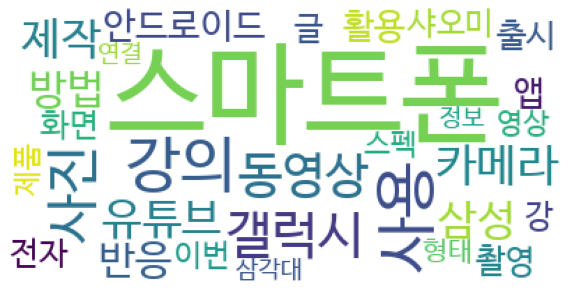

In [ ]:
import matplotlib.pyplot as plt
figure = plt.figure()
figure.set_size_inches(10, 10)
ax = figure.add_subplot(1, 1, 1)
ax.axis("off")
ax.imshow(galexy_wc)

### 형용사 빈도를 단어 구름으로 표시하기

In [ ]:
from wordcloud import WordCloud
galexy_wc = WordCloud(background_color="white", font_path='./font/NanumBarunGothic.ttf')
galexy_wc.generate_from_frequencies(galexy_top_adj)

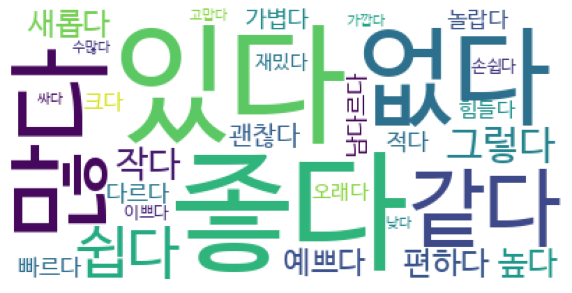

In [ ]:
import matplotlib.pyplot as plt
figure = plt.figure()
figure.set_size_inches(10, 10)
ax = figure.add_subplot(1, 1, 1)
ax.axis("off")
ax.imshow(galexy_wc)

### 단어 구름 바탕 그림 변경하기

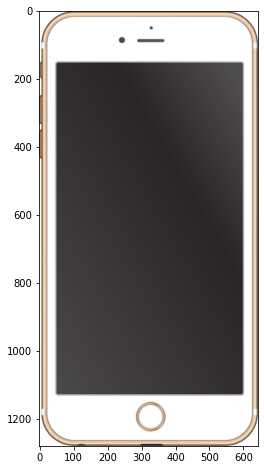

In [ ]:
from PIL import Image
import numpy as np
cloud_mask=np.array(Image.open('./data/cloud.png')) 
plt.figure(figsize=(8,8))
plt.imshow(cloud_mask,interpolation="bilinear")
plt.show()

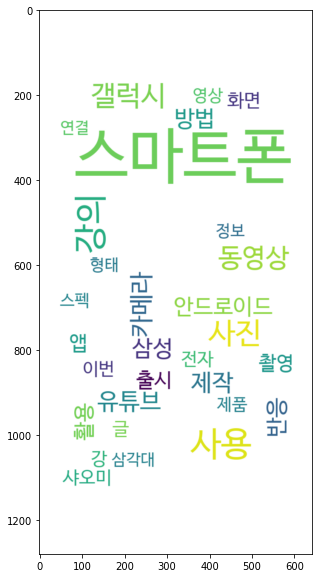

In [ ]:
galexy_wc = WordCloud(background_color="white", mask=cloud_mask, font_path='./font/NanumBarunGothic.ttf')
galexy_wc.generate_from_frequencies(galexy_top_nouns)
plt.figure(figsize=(10,10))
plt.imshow(galexy_wc,interpolation="bilinear")
plt.axis("on")
plt.show()

## TF-IDF 계산


블로그 내용에서 빈도가 높은 단어에 대해서 TF-IDF 값을 구하기 위해서 TfidfVectorizer 라이브러리를 import 한다. 그리고 추출한 50개의 명사가 블로그 내용에서 어떤 TF-IDF 값을 가지는지 배열 형태로 출력한다.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
galexy_tfidv = TfidfVectorizer().fit(galexy_top_nouns)
galexy_tfidv.transform(galexy_posts).toarray()

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

TF-IDF 값에 대해서 테이블 형태로 살펴보기위해 DataFrame을 이용하여 출력한다.

In [ ]:
pd.DataFrame(galexy_tfidv.transform(galexy_posts).toarray())
df2=pd.DataFrame(galexy_tfidv.transform(galexy_posts).toarray())
df2[100:110]

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
100,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
101,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
102,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
103,0.0,0.000000,0.0,0.0,0.0,0.447214,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
104,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
105,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.707107,0.0
106,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
107,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
108,0.0,0.894427,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
109,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


# 의미 연결망 분석(Semantic Network Analysis)

#### 주요 단어 20개를 가지고 의미 네트워크를 만들어 중심성 지수를 구하기 위해 먼저 필요한 라이브러리를 import 한다. 문장들을 나누기 위해 정규화 라이브러러 re를 import하고, 의미 네트워크를 사용하기 위해 networkx 라이브러리를 import 한다.

In [ ]:
import re
import networkx as nx

In [ ]:
galexy_nouns = []
for post in galexy_posts:
      if type(post) == str:
            for noun in tagger.nouns(post):
                if noun not in galexy_stop_words:
                    galexy_nouns.append(noun)
            
galexy_nouns[0:30]

['갤럭시',
 '플립',
 '달',
 '스마트폰',
 '가치',
 '반',
 '갤럭시',
 '플립',
 '스마트폰',
 '경험',
 '여기',
 '관점',
 '기존',
 '스마트폰',
 '기능',
 '유지',
 '의미',
 '스마트폰',
 '삼각대',
 '추천',
 '내',
 '돈',
 '내산',
 '리뷰',
 '스마트폰',
 '삼각대',
 '추천',
 '제품',
 '구매',
 '날']

In [ ]:
from collections import Counter  # 상위 20개 명사 추출
num_top_nouns = 20
galexy_nouns_counter = Counter(galexy_nouns)
galexy_top_nouns = galexy_nouns_counter.most_common(num_top_nouns)
galexy_top_nouns

[('스마트폰', 3206),
 ('사용', 394),
 ('강의', 388),
 ('사진', 296),
 ('갤럭시', 264),
 ('동영상', 235),
 ('카메라', 208),
 ('제작', 195),
 ('유튜브', 193),
 ('방법', 173),
 ('스마트', 171),
 ('반응', 167),
 ('안드로이드', 165),
 ('삼성', 150),
 ('활용', 147),
 ('앱', 142),
 ('출시', 135),
 ('촬영', 132),
 ('화면', 123),
 ('글', 119)]

In [ ]:
# 유사어를 통페합한 후 명사 빈도수를 계산한다

galexy_nouns_counter = Counter(galexy_nouns)
galexy_nouns_counter['스마트폰'] +=galexy_nouns_counter['스마트']
galexy_nouns_counter.pop('스마트')   # '스마트'를 '스마트폰'으로 간주하여 빈도수 계산하고 '스마트' 단어는 제외

galexy_nouns_counter['삼성'] +=galexy_nouns_counter['삼성전자']
galexy_nouns_counter.pop('삼성전자')   # '삼성전자'를 '삼성'으로 간주하여 빈도수 계산하고 '삼성전자' 단어는 제외

num_top_nouns = 20
galexy_top_nouns = galexy_nouns_counter.most_common(num_top_nouns)
galexy_top_nouns = dict(galexy_top_nouns)
galexy_top_nouns

{'스마트폰': 3377,
 '사용': 394,
 '강의': 388,
 '사진': 296,
 '갤럭시': 264,
 '동영상': 235,
 '카메라': 208,
 '제작': 195,
 '유튜브': 193,
 '삼성': 182,
 '방법': 173,
 '반응': 167,
 '안드로이드': 165,
 '활용': 147,
 '앱': 142,
 '출시': 135,
 '촬영': 132,
 '화면': 123,
 '글': 119,
 '전자': 117}

In [ ]:
print(galexy_top_nouns)

{'스마트폰': 3377, '사용': 394, '강의': 388, '사진': 296, '갤럭시': 264, '동영상': 235, '카메라': 208, '제작': 195, '유튜브': 193, '삼성': 182, '방법': 173, '반응': 167, '안드로이드': 165, '활용': 147, '앱': 142, '출시': 135, '촬영': 132, '화면': 123, '글': 119, '전자': 117}


### 블로그 내용을 문장으로 나누기
블로그 내용에 대해서 문장으로 나누기 위해서 문장의 끝을 나타내는 ';', '.', '?', '!'를 구분자로 사용한다.

In [ ]:
galexy_sentences = []
for post in galexy_posts:
    galexy_sentences.extend(re.split('; |\.|\?|\!', post))
galexy_sentences[0:10]

['갤럭시 Z 플립과 한 달, 접는 스마트폰의 가치만 남다 반으로 접을 수 있는 갤럭시 Z 플립이 접지 않는 스마트폰과 얼마나 다른 경험인가를… 여기에는 조금 복잡한 관점이 들어 있다',
 ' 기존 스마트폰의 기능성을 유지하면서 접은 것인지, 그냥 접는 의미만 살린',
 '',
 '',
 ' ',
 '스마트폰 삼각대 추천 내돈내산 리뷰 그래서 스마트폰 삼각대 추천 하는 제품을 구매하게 된 것 같아요',
 ' 2018년 4월 4일 날 결제해서 2021년 7월',
 '',
 '',
 ' 이 제품 구매하기 전에 다른 브랜드 스마트폰 삼각대를 구매해서 사용했었는데 폰을 너무 허술하게']

### 문장별 명사 추출
블로그 내용을 문장별로 구분하였고, 구분된 문장 별로 명사를 추출하여 정리한다.

In [ ]:
galexy_sentences_nouns = []
for sentence in galexy_sentences:
    sentence_nouns = tagger.nouns(sentence)
    galexy_sentences_nouns.append(sentence_nouns)
print(galexy_sentences_nouns[0:10])

[['갤럭시',
  '플립',
  '달',
  '스마트폰',
  '가치',
  '반',
  '수',
  '갤럭시',
  '플립',
  '스마트폰',
  '경험',
  '여기',
  '관점'],
 ['기존', '스마트폰', '기능', '유지', '것', '의미'],
 [],
 [],
 [],
 ['스마트폰',
  '삼각대',
  '추천',
  '내',
  '돈',
  '내산',
  '리뷰',
  '스마트폰',
  '삼각대',
  '추천',
  '제품',
  '구매',
  '것'],
 ['년', '월', '일', '날', '결제', '년', '월'],
 [],
 [],
 ['제품', '구매', '전', '브랜드', '스마트폰', '삼각대', '구매', '사용', '폰']]

### 상위 단어에 대해 id 적용
상위 단어 top_nouns에 대해서 key에 해당하는 단어, value에 해당하는 id를 넣어 딕셔너리 형태(word2id)로 저장한다.

In [ ]:
galexy_word2id = {w: i for i, w in enumerate(galexy_top_nouns.keys())}
print(galexy_word2id)

{'스마트폰': 0,
 '사용': 1,
 '강의': 2,
 '사진': 3,
 '갤럭시': 4,
 '동영상': 5,
 '카메라': 6,
 '제작': 7,
 '유튜브': 8,
 '삼성': 9,
 '방법': 10,
 '반응': 11,
 '안드로이드': 12,
 '활용': 13,
 '앱': 14,
 '출시': 15,
 '촬영': 16,
 '화면': 17,
 '글': 18,
 '전자': 19}

상위 단어 top_nouns에 대해서 key에 해당하는 id, value에 해당하는 단어를 넣어 딕셔너리 형태(id2word)로 저장한다.

In [ ]:
galexy_id2word = {i: w for i, w in enumerate(galexy_top_nouns.keys())}
galexy_id2word

{0: '스마트폰',
 1: '사용',
 2: '강의',
 3: '사진',
 4: '갤럭시',
 5: '동영상',
 6: '카메라',
 7: '제작',
 8: '유튜브',
 9: '삼성',
 10: '방법',
 11: '반응',
 12: '안드로이드',
 13: '활용',
 14: '앱',
 15: '출시',
 16: '촬영',
 17: '화면',
 18: '글',
 19: '전자'}

### 인접행렬 생성
상위 단어들에 대해서 상위 갯수만큼의 인접 행렬을 만들고, 문장 내에 상위 단어가 함께 포함된 비중에 따라 가중치를 계산하여 행렬에 표현한다. 인접 행렬을 생성하기 위해서 이전에 생성해둔 word2id를 이용한다. 행렬에서 만약 가중치가 0 이상이면 서로 연결되어 있음을 의미한다.

In [ ]:
import numpy as np
galexy_adjacent_matrix = np.zeros((num_top_nouns, num_top_nouns), int)
for sentence in galexy_sentences_nouns:
    for wi, i in galexy_word2id.items():
        if wi in sentence:
            for wj, j in galexy_word2id.items():
                if i != j and wj in sentence:
                    galexy_adjacent_matrix[i][j] += 1
galexy_adjacent_matrix

array([[  0, 278, 130, 168, 172, 154, 121, 139, 141, 110, 142, 142, 118,
        124,  86, 103,  84,  74, 115,  93],
       [278,   0,   0,  16,  37,   6,  22,   1,   2,  13,  55,  20,  46,
         11,  34,   8,   9,  12,   5,   9],
       [130,   0,   0,  18,   0,  94,   0, 108,  98,   1,   0,  62,   0,
         44,   0,   0,  25,   0,  13,   0],
       [168,  16,  18,   0,  11,  10,  49,   8,   6,  13,  11,   3,   0,
         22,   3,   0,  32,   3,   9,   0],
       [172,  37,   0,  11,   0,  13,  13,   0,   0,  76,  45,  11,  17,
          2,  16,  10,   5,  12,  18,   0],
       [154,   6,  94,  10,  13,   0,   0, 108, 119,   3,   0,  63,   0,
         41,   6,   2,  25,   9,  11,   0],
       [121,  22,   0,  49,  13,   0,   0,   0,   0,   7,   4,  11,   0,
          6,  11,   5,  13,   5,   3,   0],
       [139,   1, 108,   8,   0, 108,   0,   0, 115,   0,   1,  62,   0,
         40,   0,   0,  18,   0,  11,   0],
       [141,   2,  98,   6,   0, 119,   0, 115,   0,   0,   2,  

인접 행렬에 대해서 네트워크를 만들고, 네트워크에 포함된 인접 행렬에 대한 결과를 살펴본다.

In [ ]:
galexy_network = nx.from_numpy_matrix(galexy_adjacent_matrix)
list(galexy_network.adjacency())

[(0,
  {1: {'weight': 278},
   2: {'weight': 130},
   3: {'weight': 168},
   4: {'weight': 172},
   5: {'weight': 154},
   6: {'weight': 121},
   7: {'weight': 139},
   8: {'weight': 141},
   9: {'weight': 110},
   10: {'weight': 142},
   11: {'weight': 142},
   12: {'weight': 118},
   13: {'weight': 124},
   14: {'weight': 86},
   15: {'weight': 103},
   16: {'weight': 84},
   17: {'weight': 74},
   18: {'weight': 115},
   19: {'weight': 93}}),
 (1,
  {0: {'weight': 278},
   3: {'weight': 16},
   4: {'weight': 37},
   5: {'weight': 6},
   6: {'weight': 22},
   7: {'weight': 1},
   8: {'weight': 2},
   9: {'weight': 13},
   10: {'weight': 55},
   11: {'weight': 20},
   12: {'weight': 46},
   13: {'weight': 11},
   14: {'weight': 34},
   15: {'weight': 8},
   16: {'weight': 9},
   17: {'weight': 12},
   18: {'weight': 5},
   19: {'weight': 9}}),
 (2,
  {0: {'weight': 130},
   3: {'weight': 18},
   5: {'weight': 94},
   7: {'weight': 108},
   8: {'weight': 98},
   9: {'weight': 1},
   11

생성된 네트워크에 대해서 갤럭시 데이터와 아이폰 데이터를 시각화하여 나타낸다. 여기서 labels 값으로 이전에 생성한 id2word를 이용한다.

findfont: Font family ['./font/NanumBarunGothic.ttf'] not found. Falling back to DejaVu Sans.


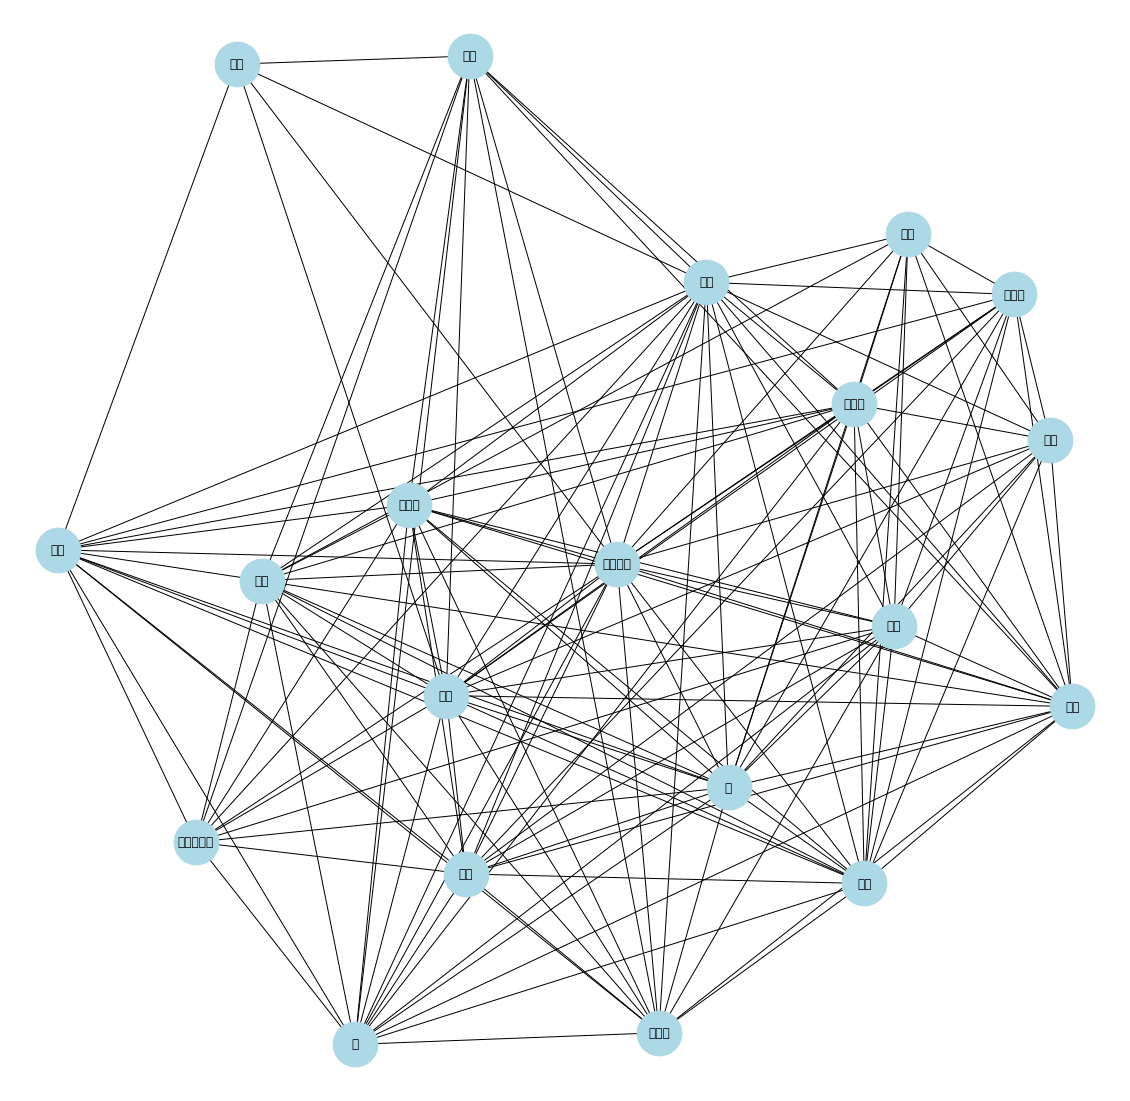

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
from matplotlib import rc

font_name = './font/NanumBarunGothic.ttf'
rc('font', family=font_name)

fig = plt.figure()
fig.set_size_inches(20, 20)
ax = fig.add_subplot(1, 1, 1)
ax.axis("off")
option = {
    'node_color' : 'lightblue',
    'node_size' : 2000,
#     'size' : 2
}
nx.draw(galexy_network, labels=galexy_id2word, font_family=font_name, ax=ax, **option)

의미 네트워크를 표현하는 다양한 시각화 방법이 존재한다. 여기서는 Random Layout, Circular Layout, Spectral Layout, Spring Layout 형태로 시각화하여 표현한다.

ValueError: Received invalid argument(s): size

findfont: Font family ['./font/NanumBarunGothic.ttf'] not found. Falling back to DejaVu Sans.
findfont: Font family ['./font/NanumBarunGothic.ttf'] not found. Falling back to DejaVu Sans.


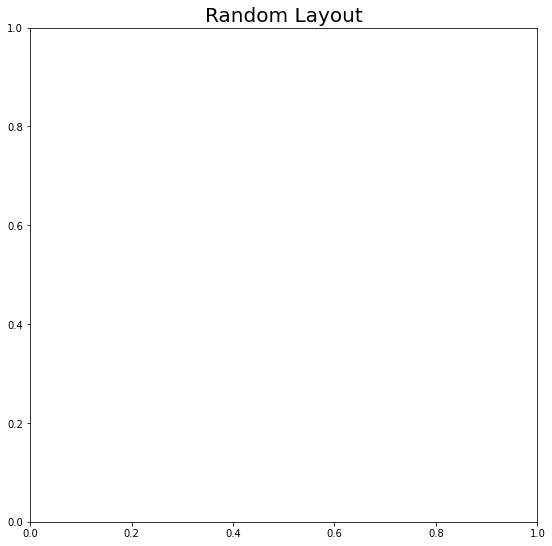

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 20)
option = {
    'node_color' : 'lightblue',
    'node_size' : 500,
    'size' : 100
}

plt.subplot(221)
plt.title('Random Layout', fontsize=20)
nx.draw_random(galexy_network, labels=galexy_id2word, font_family=font_name, **option)
plt.subplot(222)
plt.title('Circular Layout', fontsize=20)
nx.draw_circular(galexy_network, labels=galexy_id2word, font_family=font_name, **option)
plt.subplot(223)
plt.title('Spectral Layout',fontsize=20)
nx.draw_spectral(galexy_network, labels=galexy_id2word, font_family=font_name, **option)
plt.subplot(224)
plt.title('Spring Layout',fontsize=20)
nx.draw_spring(galexy_network, labels=galexy_id2word, font_family=font_name, **option)

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 20)
option = {
    'node_color' : 'lightblue',
    'node_size' : 2000,
    'size' : 100
}

plt.subplot(111)
plt.title('Random Layout', fontsize=20)
nx.draw_random(galexy_network, labels=galexy_id2word, font_family=font_name, **option)

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 20)
option = {
    'node_color' : 'lightblue',
    'node_size' : 2000,
    'size' : 100
}

plt.subplot(111)
plt.title('Circular Layout', fontsize=20)
nx.draw_circular(galexy_network, labels=galexy_id2word, font_family=font_name, **option)

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 20)
option = {
    'node_color' : 'lightblue',
    'node_size' : 2000,
    'size' : 100
}

plt.subplot(111)
plt.title('Spectral Layout',fontsize=20)
nx.draw_spectral(galexy_network, labels=galexy_id2word, font_family=font_name, **option)

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 20)
option = {
    'node_color' : 'lightblue',
    'node_size' : 2000,
    'size' : 100
}

plt.subplot(111)
plt.title('Spring Layout',fontsize=20)
nx.draw_spring(galexy_network, labels=galexy_id2word, font_family=font_name, **option)

## 중심성 지수 구하기

의미 네트워크에서 사용되는 여러 중심성 지수들이 있다. NetworkX 라이브러리에는 수 많은 중심성 지수 함수가 포함되어 있다. 이 중에서 degree centrality, eigenvector centrality, closeness centrality, current flow closeness centrality, current flow betweenness centrality, communicability betweenness centrality 중심성 지수를 수행해보도록 한다.

In [ ]:
#Degree 연결중심성
nx.degree_centrality(galexy_network)

In [ ]:
def f2(x):
   return x[1]

res = sorted(nx.degree_centrality(galexy_network).items(), key=f2, reverse=True) # 내림차순 정렬
for i in range(len(res)):
    print(res[i])

In [ ]:
#Current Flow Betweenness, 매개중심성
nx.current_flow_betweenness_centrality(galexy_network)

In [ ]:
def f2(x):
   return x[1]

res = sorted(nx.current_flow_betweenness_centrality(galexy_network).items(), key=f2, reverse=True)
#print(res)
for i in range(len(res)):
    print(res[i])

In [ ]:
#Closeness, 근접중심성
nx.closeness_centrality(galexy_network, distance='weight')

In [ ]:
res = sorted(nx.closeness_centrality(galexy_network, distance='weight').items(), key=f2, reverse=True)
for i in range(len(res)):
    print(res[i])

In [ ]:
#Eigenvector, 위세중심성
nx.eigenvector_centrality(galexy_network, weight='weight')

In [ ]:
def f2(x):    # 함수정의 생략가능
   return x[1]

res = sorted(nx.eigenvector_centrality(galexy_network, weight='weight').items(), key=f2)  # 올림차순 정렬
for i in range(len(res)):
    print(res[i])

# 토픽 모델링(Topic Modeling)


## Gensim 라이브러리
토픽 모델링을 사용하기 위해서는 gensim 라이브러리를 사용해야 한다. gensim을 사용하기 위해서 pip install gensim 명령어를 통해 라이브러리를 설치한다. 

In [ ]:
galexy_nouns = []   # 명사 추출하기
nouns = []
for post in galexy_posts:
    if type(post) == str:
        for noun in tagger.nouns(post):
            if noun not in galexy_stop_words:
                nouns.append(noun)
        galexy_nouns.append(nouns)
    else:
        galexy_nouns.append(['nouns'])
        
galexy_nouns[0:10]

In [ ]:
!pip install gensim

####  명사에 대해서 bigram 형태로 만들어 사용한다. 그리고 bigram으로 묶인 명사에 대해서 trigram을 만들어 사용한다.

In [ ]:
import gensim
galexy_bigram = gensim.models.Phrases(galexy_nouns)
galexy_trigram = gensim.models.Phrases(galexy_bigram[galexy_nouns])
galexy_bigram_model = gensim.models.phrases.Phraser(galexy_bigram)
galexy_trigram_model = gensim.models.phrases.Phraser(galexy_trigram)

In [ ]:
from gensim import corpora
galexy_bigram_document = [galexy_bigram_model[nouns] for nouns in galexy_nouns]
galexy_bigram_document[1]

bigram 문서에 대해서 id와 word로 매핑된 딕셔너리를 생성한다. 그리고 doc2bow 함수를 통해서 (단어, 빈도수) 형태로 변환한다.

In [ ]:
galexy_id2word = corpora.Dictionary(galexy_bigram_document)
galexy_corpus = [galexy_id2word.doc2bow(doc) for doc in galexy_bigram_document]
galexy_corpus[0]

In [ ]:
galexy_id2word[2000] #2000번째 단어가 무엇인지 확인

### Topic Coherence 계산
토픽 모델링을 수행함에 있어서 적절한 토픽의 갯수를 찾는 것이 중요하다. 2부터 9까지 값을 늘려가면서 LDA 모델을 생성하여 각 모델의 coherence를 계산한다. 그리고 적절한 토픽의 수는 토픽 개수를 늘려가며 높은 coherence score를 가지는 값으로 결정한다.

In [ ]:
from gensim.models import CoherenceModel
from tqdm import tqdm

galexy_coherence_score=[]
for i in tqdm(range(2,10)):
    model = gensim.models.ldamodel.LdaModel(corpus=galexy_corpus, id2word=galexy_id2word, num_topics=i)
    coherence_model = CoherenceModel(model, texts=galexy_bigram_document, dictionary=galexy_id2word, coherence='c_v')
    coherence_lda = coherence_model.get_coherence()
    print('n=',i,'\nCoherence Score: ', coherence_lda)
    galexy_coherence_score.append(coherence_lda)

토픽의 적절한 개수를 찾기 위해서 계산한 coherence score를 차트로 나타내서 살펴본다.

In [ ]:
import matplotlib.pyplot as plt  
import numpy

k=[]
for i in range(2,10):
    k.append(i)

x=numpy.array(k)
y=numpy.array(galexy_coherence_score)
plt.title('Galexy Topic Coherence')
plt.plot(x,y)
plt.xlim(2,10)
plt.xlabel('Number Of Topic (2-10)')
plt.ylabel('Cohrence Score')
plt.show()

### 토픽의 갯수가 증가할수록 계속적으로 coherence score가 증가하는 추이를 보인다. 증가 추이에서 가장 높은 값을 가지다가 낮아지기 시작하는 지점이 적절한 토픽의 갯수로 판단하고, LDA 모델을 생성한다.

In [ ]:
galexy_model = gensim.models.ldamodel.LdaModel(corpus=galexy_corpus, id2word=galexy_id2word, num_topics=4)
galexy_model.print_topics()

### pyLDAvis를 이용한 LDA 시각화 IDM
LDA를 시각화하기 pyLDAvis 라이브러리를 import 해야 한다. pyLDAvis 라이브러리는 명령어 pip install pyLDAvis를 이용하여 설치해야 한다. 설치가 완료되면 실제 생성한 모델을 가지고 토픽간 거리지도(IDM)으로 시각화한다. 

In [ ]:
!pip install pyLDAvis

In [ ]:
import pyLDAvis
import pyLDAvis.gensim as gensimvis
prepared_data = gensimvis.prepare(galexy_model, galexy_corpus, galexy_id2word)
pyLDAvis.display(prepared_data)

## 동적 토픽 모델링(Dynamic Topic Modeling)

동적 토픽 모델링을 적용하기 위해서 텍스트 데이터에서 시간에 따른 분류로 전처리한다. 각 데이터는 특정 시간에 포함된 문서들의 단어들로 분류가 된다.

In [ ]:
galexy_nouns_date={}
for i in range(len(galexy_posts)):
    if galexy_post_date[i] in galexy_nouns_date:
        galexy_nouns_date[galexy_post_date[i]].append(galexy_nouns[i])
    else:
        galexy_nouns_date[galexy_post_date[i]]=[]
        galexy_nouns_date[galexy_post_date[i]].append(galexy_nouns[i])

galexy_nouns_date = sorted(galexy_nouns_date.items())
galexy_nouns_date[0]

시간에 따라 분류된 명사들이 있는 데이터에서 시간별로 명사들이 있는 문서의 개수를 계산한다.

In [ ]:
galexy_nouns_dates=[]
galexy_date_length=[]
for i in range(len(galexy_nouns_date)):
    galexy_nouns_dates.append(galexy_nouns_date[i][1])
    galexy_date_length.append(len(galexy_nouns_date[i][1]))

galexy_date_length[0:20]

시간별로 명사들이 있는 데이터를 하나로 통합한다.

In [ ]:
galexy_merged_dates=[]
for posts in galexy_nouns_dates:
    for post in posts:
        galexy_merged_dates=galexy_merged_dates+[post]

galexy_merged_dates[0]

이전에 따로 수행하던 토픽 모델링에 필요한 과정을 docLDA 함수를 정의하여 사용한다. docLDA는 명사들을 bigram, trigram으로 만들고 LDA model, corpus, id2word를 생성한다. docLDA 함수를 사용하여 한번에 토픽 모델링에 필요한 요소들을 생성하고, 각 토픽들에 대해서 출력하여 살펴본다.

In [ ]:
import gensim
from gensim import corpora

def docLDA(nouns):
    bigram = gensim.models.Phrases(nouns)
    trigram = gensim.models.Phrases(bigram[nouns])
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    bigram_document = [bigram_mod[doc] for doc in nouns]
    id2word = corpora.Dictionary(bigram_document)

    corpus = [id2word.doc2bow(doc) for doc in bigram_document]
    model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=4)
    
    return model, corpus, id2word

In [ ]:
galexy_model, galexy_corpus, galexy_id2word = docLDA(galexy_nouns)
galexy_model.print_topics()

getTopics 함수는 LDA 모델에 포함된 각 토픽들에 대해서 반환한다. 블로그 텍스트에서 getTopics 함수를 통해 토픽들을 살펴본다.

In [ ]:
def getTopics(model):
    topics = []
    for topic in model.print_topics():
        i=1
        model_words=[]
        topic_words=str(topic).split('"')
        for words in topic_words:
            if i%2==0:
                model_words.append(words)
            i+=1
        topics.append(model_words)
    return topics

In [ ]:
galexy_topics = getTopics(galexy_model)
galexy_topics

동적 토픽 모델로 살펴보기 위해 문서마다 가지고 있는 토픽들의 크기를 알아야 한다. 여기서는 날짜별로 합쳐진 문서마다 토픽들의 크기를 계산한다.

In [ ]:
galexy_topic_size=[]
index=0
for post_len in galexy_date_length:
    topic_size=[]
    doc=[]
    for i in range(post_len):
        doc+=galexy_merged_dates[index]
        index+=1
    for model in galexy_topics:
        count=0
        for noun in doc:
            if noun in model:
                count+=1
        topic_size.append(count)
    galexy_topic_size.append(topic_size)

galexy_topic_size[0:10]

Numpy의 배열 형태로 저장하기 위해 변환한다.

In [ ]:
import numpy as np
galexy_topic_array=np.array(galexy_topic_size)
galexy_topic_array

matplotlib를 이용하여 차트로 시각화하여 시간에 따른 토픽들의 변화를 살펴본다. 차트에서 x축은 시간이 나타내고, y축은 토픽의 크기가 된다.

In [ ]:
import matplotlib.pyplot as plt
import datetime as dt

galexy_x=[]
galexy_y=[]

galexy_topic_1=galexy_topic_array[:,0]
galexy_topic_2=galexy_topic_array[:,1]
galexy_topic_3=galexy_topic_array[:,2]
galexy_topic_4=galexy_topic_array[:,3]

galexy_unique_date=sorted(list(set(galexy_post_date)))
galexy_plt_data=[]
for date in galexy_unique_date:
    times= dt.datetime.strptime(str(date),'%Y%m%d')
    galexy_x.append(times)

plt.rcParams["figure.figsize"]=(15,10)
plt.title("Galexy DTM")
plt.plot(galexy_x, galexy_topic_1,'o-', label="Topic 1")
plt.plot(galexy_x, galexy_topic_2,'o-', label="Topic 2")
plt.plot(galexy_x, galexy_topic_3,'o-', label="Topic 3")
plt.plot(galexy_x, galexy_topic_4,'o-', label="Topic 4")

plt.legend()
plt.show()

# Word2Vec
Word2Vec은 단어 임베딩(embedding)을 하는 방법으로 여기서는 skip-gram 모델을 이용해 단어를 벡터로 변환하고 TSNE 알고리즘으로 시각화 한다.

### Word2Vec 생성 및 시각화
Word2Vec을 생성하고 시각화하기 위해서는 gensim.models의 Word2Vec 라이브러리를 import한다. 그리고 시각화를 위해서 TSNE 라이브러리를 import한다.

In [ ]:
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from matplotlib import font_manager as fm
from matplotlib import rc

In [ ]:
galexy_nouns = []   # 명사 추출하기
nouns = []
for post in galexy_posts:
    if type(post) == str:
        for noun in tagger.nouns(post):
            if noun not in galexy_stop_words:
                nouns.append(noun)
        galexy_nouns.append(nouns)
    else:
        galexy_nouns.append(['nouns'])
        
galexy_nouns[0:10]

In [ ]:
galexy_word2vec = Word2Vec(galexy_nouns, min_count=1)
galexy_word2vec

생성된 데이터의 Word2Vec 모델에서 핵심어와 유사한 단어를 출력한다.

In [ ]:
galexy_word2vec.wv.most_similar("스마트폰")

Word2Vec을 2차원으로 시각화를 위해서 n_components가 2인 TSNE를 생성한다.

In [ ]:
galexy_tsne = TSNE(n_components=2)
galexy_tsne

Word2Vec으로 나온 어휘에서 유사도를 계산한다.

In [ ]:
galexy_vocab = galexy_word2vec.wv.vocab
galexy_similarity = galexy_word2vec[galexy_vocab]
galexy_similarity

벡터의 유사도를 2차원으로 변환하여 DataFrame으로 살펴본다.

In [ ]:
galexy_transform_similarity = galexy_tsne.fit_transform(galexy_similarity)
galexy_df = pd.DataFrame(galexy_transform_similarity, index=galexy_vocab, columns=['x', 'y'])
galexy_df[0:10]

Word2Vec 모델에 대해서 TSNE를 통해 2차원으로 시각화하여 나타낸다. annotate(word, pos)로 벡터 위치에 단어를 annotation 하는 형태로 만들고, matplotlib를 이용하여 시각화한다.

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
from matplotlib import rc

font_name = 'Malgun Gothic'
rc('font', family=font_name)

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig.set_size_inches(20, 20)

ax = fig.add_subplot(1, 1, 1)
ax.scatter(galexy_df['x'], galexy_df['y'])
for word, pos in galexy_df.iterrows():
    ax.annotate(word, pos)
ax.axis("off")

In [ ]:
galexy_word2vec.wv.most_similar("스마트폰")

NameError: name 'galexy_word2vec' is not defined

# 군집 분석


### k-Means를 이용한 비계층적 군집분석
비계층적 군집화를 위해서 먼저 KMeans 라이브러리와 AgglomerativeClustering 라이브러리를 import한다. 그리고 군집화를 하기 전에 matplotlib를 이용하여 단어를 벡터로 변환하여 시각화한다.

In [ ]:
galexy_post_nouns = []   # 문서별로 명사 추출하기
for post in galexy_posts:
    if type(post) == str:
        post_nouns = tagger.nouns(post)
        for i in range(len(post_nouns)-1, 0, -1):
            if post_nouns[i] in galexy_stop_words:
                del post_nouns[i]
        galexy_post_nouns.append(post_nouns)
          
galexy_post_nouns[0:10]

In [ ]:
# 문서별로 추출한 명사들을 띄어쓰기를 붙여서 목록형(list)으로 만들기
for i in range(len(galexy_post_nouns)):
    galexy_post_nouns[i] = ' '.join(galexy_post_nouns[i])

print(galexy_post_nouns)

In [ ]:
# 군집분석에 필요한 라이브러리 설치

from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from matplotlib import font_manager as fm
from matplotlib import rc
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc


In [ ]:
#===============K means 클러스터 분석========================
vec = CountVectorizer() # 단어빈도 기준으로 문서-단어 메트릭스DTM 생성
X = vec.fit_transform(galexy_post_nouns)
df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
df.tail()

In [ ]:
# 어휘빈도_문서역빈도(TF-IDF) 기준으로 문서-단어 메트릭스DTM 생성

from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer() 
X = vec.fit_transform(galexy_post_nouns)
df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
df[10:20]

클러스터의 개수 n_clusters가 3개인 KMeans 모델을 생성한다. 그리고 모델을 통해 나온 결과를 저장한다.

In [ ]:
kmeans = KMeans(n_clusters=3).fit(df) # 군집수가 3인 비계층적 군집분석 시행
kmeans.labels_ # 각 문서가 어느 군집에 속하는지 표시

In [ ]:
# 주성분분석(PCA)을 통해 데이터 분석결과를 2차원으로 변환하여 보여준다.
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

 
principalDf.index=galexy_posts

kmeans.labels_ == 0

# x축 : first y출 : second 번호로 나타낸후 plot으로 시각화
plt.scatter(principalDf.iloc[kmeans.labels_ == 0, 0], principalDf.iloc[kmeans.labels_ == 0, 1], s = 10, c = 'red', label = 'cluster1')
plt.scatter(principalDf.iloc[kmeans.labels_ == 1, 0], principalDf.iloc[kmeans.labels_ == 1, 1], s = 10, c = 'blue', label = 'cluster2')
plt.scatter(principalDf.iloc[kmeans.labels_ == 2, 0], principalDf.iloc[kmeans.labels_ == 2, 1], s = 10, c = 'green', label = 'cluster3')
plt.legend()


## 계층적 군집분석

### 와드에 의한 연결법

In [ ]:
# 와드연결법으로 군집이 3개가 되도록 만들어 각 문서가 속한 군집을 배열형 데이터로 반환

cluster = AgglomerativeClustering(n_clusters=3, linkage='ward')  
cluster.fit_predict(df)  

In [ ]:
 # 와드연결법의 덴드로그램으로 시각화
    
plt.figure(figsize=(10, 7))  
plt.title("Customer Dendograms")  
dend = shc.dendrogram(shc.linkage(df, method='ward'))

### 완전 연결법

In [ ]:
plt.figure(figsize=(30, 20))  # 완전연결법의 덴드로그램으로 시각화
plt.title("Customer Dendograms")  
dend = shc.dendrogram(shc.linkage(df, method='complete'))

## 군집분석으로 나누어진 하위 집단에 대한 추가적인 분석

### 3개 하위군집으로 나누기

In [ ]:
sub_gr = kmeans.labels_
sub_gr[100:120]

In [ ]:
sub_1, sub_2, sub_3 = [], [], []

In [ ]:
for i in range(len(sub_gr)):
    if sub_gr[i] == 0:
        sub_1.append(galexy_post_nouns[i])
    elif sub_gr[i] == 1:
        sub_2.append(galexy_post_nouns[i])
    else:
        sub_3.append(galexy_post_nouns[i])

In [ ]:
print(len(sub_1))
print(sub_1[0])

In [ ]:
print(len(sub_2))
print(sub_2[0])

In [ ]:
print(len(sub_3))
print(sub_3[0])

In [ ]:
def devide(sub_x):
    result = []
    for i in range(len(sub_x)):
        temp = sub_x[i].split(' ')
        for j in range(len(temp)):
            result.append(temp[j])
    return result

In [ ]:
sub_1 = devide(sub_1)
sub_2 = devide(sub_2)
sub_3 = devide(sub_3)

NameError: name 'devide' is not defined

### 군집1의 핵심어 빈도분석

In [ ]:
from collections import Counter  # 상위 30개 명사 추출
num_top_nouns = 30
galexy_nouns_counter = Counter(sub_1)
galexy_top_nouns = galexy_nouns_counter.most_common(num_top_nouns)
galexy_top_nouns

In [ ]:
galexy_top_nouns = dict(galexy_top_nouns)

In [ ]:
from wordcloud import WordCloud
galexy_wc = WordCloud(background_color="white", font_path='./font/NanumBarunGothic.ttf')
galexy_wc.generate_from_frequencies(galexy_top_nouns)

In [ ]:
import matplotlib.pyplot as plt
figure = plt.figure()
figure.set_size_inches(10, 10)
ax = figure.add_subplot(1, 1, 1)
ax.axis("off")
ax.imshow(galexy_wc)

### 군집2의 핵심어 빈도분석

In [ ]:
from collections import Counter  # 상위 30개 명사 추출
num_top_nouns = 30
galexy_nouns_counter = Counter(sub_2)
galexy_top_nouns = galexy_nouns_counter.most_common(num_top_nouns)
galexy_top_nouns

In [ ]:
galexy_top_nouns = dict(galexy_top_nouns)

In [ ]:
from wordcloud import WordCloud
galexy_wc = WordCloud(background_color="white", font_path='./font/NanumBarunGothic.ttf')
galexy_wc.generate_from_frequencies(galexy_top_nouns)

In [ ]:
import matplotlib.pyplot as plt
figure = plt.figure()
figure.set_size_inches(10, 10)
ax = figure.add_subplot(1, 1, 1)
ax.axis("off")
ax.imshow(galexy_wc)

### 군집3의 핵심어 빈도분석

In [ ]:
from collections import Counter  # 상위 30개 명사 추출
num_top_nouns = 30
galexy_nouns_counter = Counter(sub_3)
galexy_top_nouns = galexy_nouns_counter.most_common(num_top_nouns)
galexy_top_nouns

In [ ]:
galexy_top_nouns = dict(galexy_top_nouns)

In [ ]:
from wordcloud import WordCloud
galexy_wc = WordCloud(background_color="white", font_path='./font/NanumBarunGothic.ttf')
galexy_wc.generate_from_frequencies(galexy_top_nouns)

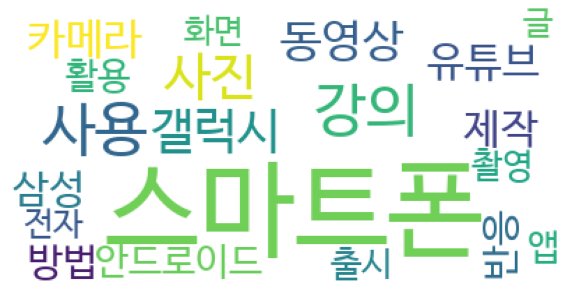

In [ ]:
import matplotlib.pyplot as plt
figure = plt.figure()
figure.set_size_inches(10, 10)
ax = figure.add_subplot(1, 1, 1)
ax.axis("off")
ax.imshow(galexy_wc)

# 감성 분석(Sentiment Analysis)

감성 분석을 위해서 긍정에 해당하는 딕셔너리 positive-words.txt와 부정에 해당하는 딕셔너리 negative-words.txt를 사용한다. 

In [ ]:
dic1 = open('./dict/positive-words.txt')
dic2 = open('./dict/negative-words.txt')
positive_words=[]
negative_words=[]
for line in dic1:
    positive_words.append(line.strip('\n'))
for line in dic2:
    negative_words.append(line.strip('\n'))

In [ ]:
positive_words[0:10]

['a+',
 'abound',
 'abounds',
 'abundance',
 'abundant',
 'accessable',
 'accessible',
 'acclaim',
 'acclaimed',
 'acclamation']

In [ ]:
negative_words[0:10]

[';;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;',
 '; ',
 '2-faced',
 '2-faces',
 'abnormal',
 'abolish',
 'abominable',
 'abominably',
 'abominate',
 'abomination']

영문으로 된 CEO들의 인사말에 대해서 감정분석을 수행하기 위해서 데이터를 읽는다.

In [ ]:
import pandas as pd
df = pd.read_csv('./data/CEO3.csv', encoding='latin')
df[0:10]

,number,firm,publishing,country,text,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 450,Unnamed: 451,Unnamed: 452,Unnamed: 453,Unnamed: 454,Unnamed: 455,Unnamed: 456,Unnamed: 457,Unnamed: 458,Unnamed: 459
0,2,Amorepacific,1,Korea,We will use beauty to change the world and bec...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4,Amorepacific,3,Korea,AMOREPACIFC Group will endeavor to become a gr...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,502,Amorepacific,4,Korea,AMOREPACIFIC Group has been pursuing the path ...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,Asiana Airlines,1,Korea,This year marks the 25th anniversary of the es...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6,Asiana Airlines,2,Korea,"Since the inception, Asiana Airlines has pledg...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,7,Asiana Airlines,3,Korea,All of us will do our best without stopping fo...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,503,Asiana Airlines,4,Korea,"First of all, I would like to express my heart...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,11,BNK Financial Group Inc.,3,Korea,Since the establishment of Busan Bank in 1967 ...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,504,BNK Financial Group Inc.,4,Korea,"In March 2011, BNK Financial Group was launche...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,12,BPA,3,Korea,I am pleased to introduce various sustainable ...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
firm = df.get('firm')
text = df.get('text')

company = {firm[0]:text[0]}
for i in range(len(firm)):
    if company.get(firm[i]) != None:
        company[firm[i]] = company.get(firm[i]) + "\n" + text[i]
    else:
        company[firm[i]] = text[i]

company.get('Amorepacific')

'We will use beauty to change the world and become a company that customers love. To our stakeholders, During the past 67 years, AMOREPACIFIC has embarked on a long journey of beauty to provide happiness and pleasure to people all around the world with AMOREPACIFIC¡¯s creation of beauty products. We have stood the test of numerous crises resulting from uncertain management conditions to achieve continuous growth by caring about our customers and taking quick actions to seek new opportunities. Even at this very moment, AMOREPACIFIC is striving to satisfy global customers by discovering the values of sustainable beauty found in Asia¡¯s profound wisdom, while also making concerted efforts to create a sustainable company. AMOREPACIFIC has minimized the negative impacts on the environment and strengthened the development of sustainable products and packaging materials to deliver the values of environment-friendly consumption to customers. We continually expanded the Beautiful Fair Trade to 

In [ ]:
from nltk.corpus import gutenberg
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

In [ ]:
import nltk
nltk.download('punkt')
tokens=[]
for f, t in company.items():
    token=word_tokenize(t)
    tokens.append([f,token])

[nltk_data] Downloading package punkt to /home/freesky/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


감성 분석을 위해 각 토큰마다 긍정에 해당하면 +1하고 부정에 해당하면 -1로 계산하고, 전체 단어의 수로 나누어서 각 회사마다 긍정 부정의 정도를 계산한다.

In [ ]:
sentiment_firm=[]

for token in tokens:
    firm=token[0]
    sentiment=0
    count=0
    
    for t in token[1]:
        if t in positive_words:
            sentiment+=1
            count+=1
        elif t in negative_words:
            sentiment -=1
            count+=1
    
    sentiment_firm.append([firm,sentiment/count])

sentiment_firm[0:10]

[['Amorepacific', 0.8666666666666667],
 ['Asiana Airlines', 0.768595041322314],
 ['BNK Financial Group Inc.', 0.9344262295081968],
 ['BPA', 0.8823529411764706],
 ['BS FINANCIAL GROUP INC', 0.68],
 ['CJ', 0.5555555555555556],
 ['Coway', 0.8125],
 ['Daelim', 0.75],
 ['Daewoo E&C', 0.4533333333333333],
 ['Daum Communications', 0.5652173913043478]]

각 회사마다 감성 분석된 결과를 %로 시각화하여 나타낸다.

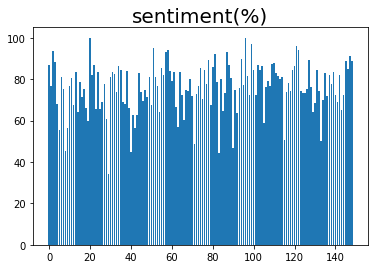

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

a=[]
for firm in sentiment_firm:
    a.append(firm[1]*100)
X=np.arange(len(a))

plt.title("sentiment(%)",fontsize=20)
plt.bar(X,a)
plt.show()

## 감성분석(세분화)

세분화된 감성 분석을 위해서는 py_lex 라이브러리를 설치해야 한다.

In [ ]:
!pip install py_lex

Defaulting to user installation because normal site-packages is not writeable


py_lex에 있는 감정 어휘집을 사용하여 매우 다양한 세부 감성에 대해서 분석에 활용할 수 있다. 먼저 엑셀 파일로 감정 어휘집을 읽어온다. 읽어온 감성 어휘집을 보면 세분화된 감성으로 Positive, Negative, Anger, Anticipation, Disgust, Fear, Joy, Sadness, Surprise, Trust를 가지고 있다.

In [ ]:
!python3 -m pip install openpyxl

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 243 kB 1.8 MB/s eta 0:00:01


In [ ]:
from py_lex import Liwc, EmoLex
import pandas as pd
emotion_dic=pd.read_excel('./dict/NRC-Emotion-Lexicon-v0.92-In105Languages-Nov2017Translations_ENG.xlsx', engine='openpyxl')
emotion_dic[0:10]

,English (en),Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,...,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49
0,aback,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,abacus,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,abandon,0,1,0,0,0,1,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,abandoned,0,1,1,0,0,1,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,abandonment,0,1,1,0,0,1,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,abate,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,abatement,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,abba,1,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,abbot,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,abbreviate,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


영문으로 된 CEO 인사말을 감성분석하기 위해서 영어로 된 감성 사전을 지정한다.

In [ ]:
df=emotion_dic.set_index('English (en)')

각 토큰에 대해서 감성 사전의 다양한 감성 정보로 세분화하여 계산한다. 즉, 각 회사마다 세분화된 감성의 정도를 계산한 결과를 가지게 된다.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

emotion_firm=[]

for token in tokens:
    firm=token[0]
    sentiment=0
    count=0
    arr=[]
    senti_count=0
    for t in token[1]:
        if t in df.index:
            count+=1
            arr.append(list(df.loc[t]))
            if np.sum(list(df.loc[t]))!=0:
                senti_count+=1
    emotion_firm.append([firm,np.sum(arr,axis=0),senti_count/count])

emotion_firm[0:10]

[['Amorepacific',
  array([218.,  16.,   6.,  57.,   4.,  20.,  97.,   6.,  14.,  82.,  nan,
          nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
          nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
          nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
          nan,  nan,  nan,  nan,  nan]),
  1.0],
 ['Asiana Airlines',
  array([147.,  14.,   9.,  49.,   5.,  15.,  41.,   4.,  17.,  89.,  nan,
          nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
          nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
          nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
          nan,  nan,  nan,  nan,  nan]),
  1.0],
 ['BNK Financial Group Inc.',
  array([96.,  6.,  2., 19.,  2.,  1., 20.,  3.,  2., 51., nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         na

시각화하여 나타내기 위해 각 회사마다 계산된 결과를 세분화된 감성으로 분류하여 저장한다.

In [ ]:
emotion_result=[]
for firm in emotion_firm:
    emotion_result.append({"Firm" : firm[0],
                           "Positive": str("%0.2f"%( firm[1][0]/(firm[1][0]+firm[1][1])*100 ))+"%",
                            "Negative" : str("%0.2f"%( firm[1][1]/(firm[1][0]+firm[1][1])*100 ))+"%",
                            "Anger" : str("%0.2f"%( firm[1][2]/(firm[1][0]+firm[1][1])*100 ))+"%",
                            "Anticipation" : str("%0.2f"%( firm[1][3]/(firm[1][0]+firm[1][1])*100 ))+"%",
                            "Disgust" : str("%0.2f"%( firm[1][4]/(firm[1][0]+firm[1][1])*100 ))+"%",
                            "Fear" : str("%0.2f"%( firm[1][5]/(firm[1][0]+firm[1][1])*100 ))+"%",
                            "Joy" : str("%0.2f"%( firm[1][6]/(firm[1][0]+firm[1][1])*100 ))+"%",
                            "Sadness" : str("%0.2f"%( firm[1][7]/(firm[1][0]+firm[1][1])*100 ))+"%",
                            "Surprise" : str("%0.2f"%( firm[1][8]/(firm[1][0]+firm[1][1])*100 ))+"%",
                            "Trust" : str("%0.2f"%( firm[1][9]/(firm[1][0]+firm[1][1])*100 ))+"%",
                            "Sentiwords / non-sentiwords (%)":str("%0.2f"%(firm[2]*100))+"%"}
                          )
emotion_result[0:10]

[{'Firm': 'Amorepacific',
  'Positive': '93.16%',
  'Negative': '6.84%',
  'Anger': '2.56%',
  'Anticipation': '24.36%',
  'Disgust': '1.71%',
  'Fear': '8.55%',
  'Joy': '41.45%',
  'Sadness': '2.56%',
  'Surprise': '5.98%',
  'Trust': '35.04%',
  'Sentiwords / non-sentiwords (%)': '100.00%'},
 {'Firm': 'Asiana Airlines',
  'Positive': '91.30%',
  'Negative': '8.70%',
  'Anger': '5.59%',
  'Anticipation': '30.43%',
  'Disgust': '3.11%',
  'Fear': '9.32%',
  'Joy': '25.47%',
  'Sadness': '2.48%',
  'Surprise': '10.56%',
  'Trust': '55.28%',
  'Sentiwords / non-sentiwords (%)': '100.00%'},
 {'Firm': 'BNK Financial Group Inc.',
  'Positive': '94.12%',
  'Negative': '5.88%',
  'Anger': '1.96%',
  'Anticipation': '18.63%',
  'Disgust': '1.96%',
  'Fear': '0.98%',
  'Joy': '19.61%',
  'Sadness': '2.94%',
  'Surprise': '1.96%',
  'Trust': '50.00%',
  'Sentiwords / non-sentiwords (%)': '100.00%'},
 {'Firm': 'BPA',
  'Positive': '88.68%',
  'Negative': '11.32%',
  'Anger': '1.89%',
  'Anticipa

세분화하여 감성 분석된 결과를 3차원으로 시각화하기 위해서 x, y, z 정보를 정의한다.

In [ ]:
y=[]
for firm in emotion_firm:
    y.append(list(firm[1][2:]))
x=['Positive','Negative','Anger','Anticipation','Disgust','Fear','Joy','Sadness','Suprise','Trust']
z=[]
for firm in emotion_firm:
    z.append(firm[0])

세부 감성대로 나온 결과를 3차원으로 시각화한다.

ValueError: shape mismatch: objects cannot be broadcast to a single shape

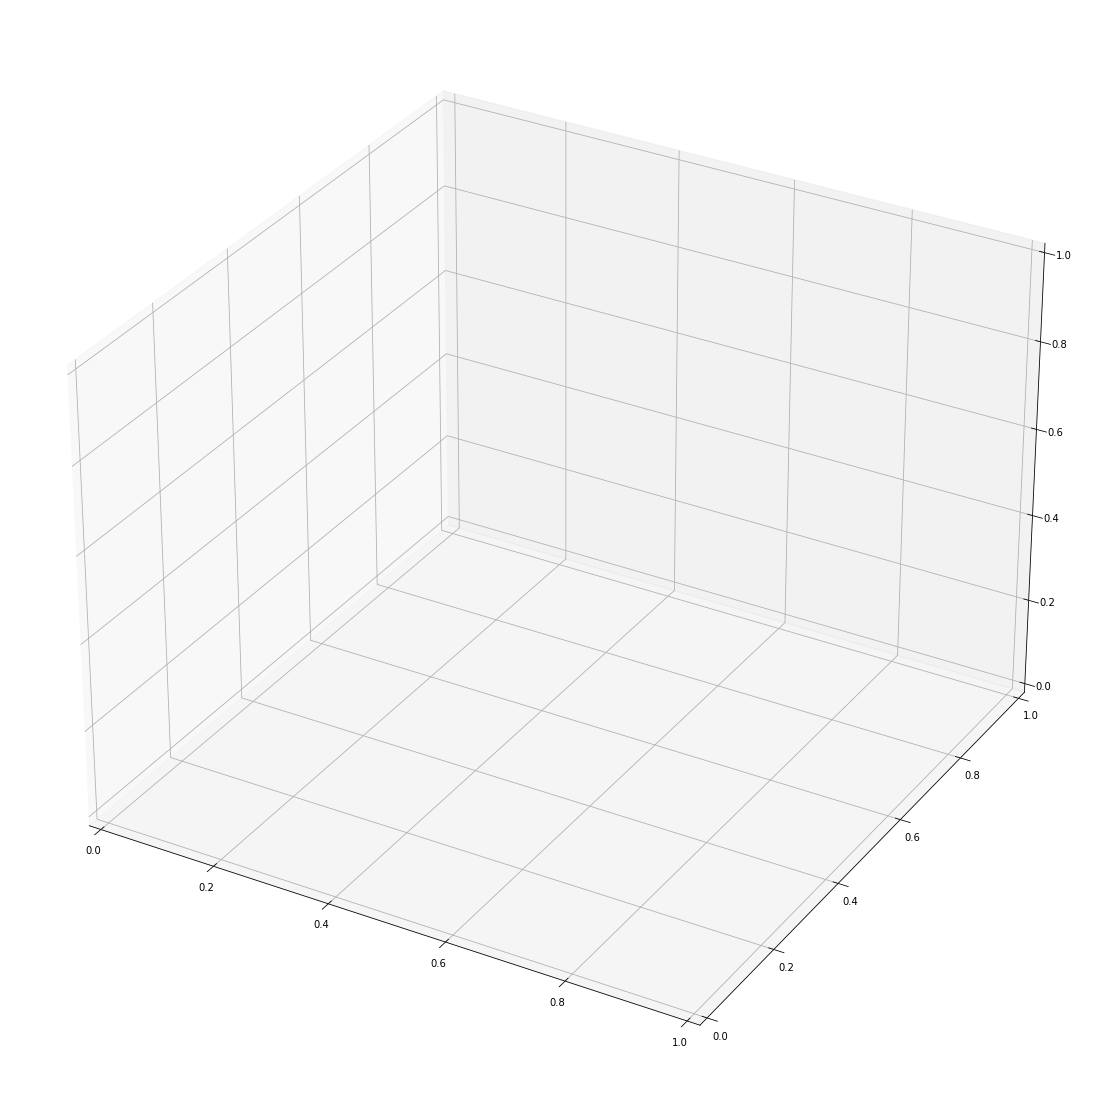

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig=plt.figure()
fig.set_size_inches(20, 20, 20)

ax = fig.add_subplot(111,projection='3d')
for firm in emotion_firm:
    xs=np.arange(8)

    ys=firm[1][2:]
    zs=emotion_firm.index(firm)
    ax.bar(xs,ys,zs,zdir='y',alpha=0.8)

plt.show()

각 회사마다 세분화하여 감성분석한 결과를 2차원 막대 그래프 형태로 시각화하여 나타낸다. 여기서 x는 회사이고, y는 감성에 해당하는 단어들의 수이며, 막대 그래프 내에 세분화된 감정들이 종류별로 시각화되어 있다.

findfont: Font family ['./font/NanumBarunGothic.ttf'] not found. Falling back to DejaVu Sans.


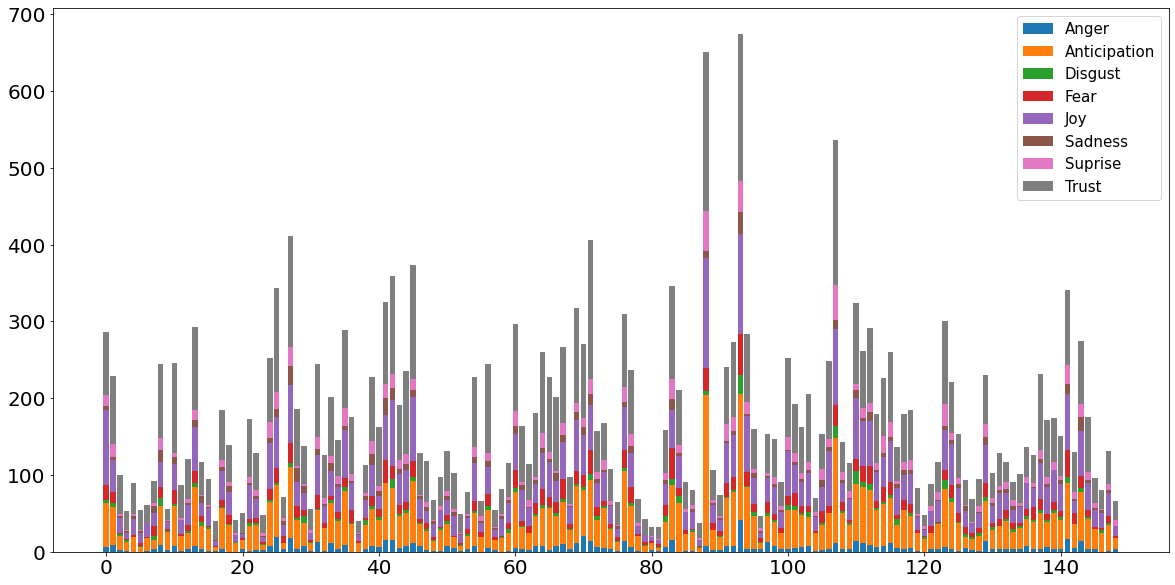

In [ ]:
E=[]
plt.rcParams["figure.figsize"]=(20,10)
plt.rcParams["ytick.labelsize"]=20
plt.rcParams["xtick.labelsize"]=20
plt.rcParams["legend.fontsize"]=15

for firm in emotion_firm:
    E.append(firm[1][2:])
a=np.transpose(E)
X=np.arange(len(a[0]))
plt.bar(X,a[0],label='Anger')
plt.bar(X,a[1],bottom=a[0],label='Anticipation')
plt.bar(X,a[2],bottom=sum(a[0:2]),label='Disgust')
plt.bar(X,a[3],bottom=sum(a[0:3]),label='Fear')
plt.bar(X,a[4],bottom=sum(a[0:4]),label='Joy')
plt.bar(X,a[5],bottom=sum(a[0:5]),label='Sadness')
plt.bar(X,a[6],bottom=sum(a[0:6]),label='Suprise')
plt.bar(X,a[7],bottom=sum(a[0:7]),label='Trust')

plt.xlabel="Firm index"
plt.legend()
plt.show()